# SQL in Python

Structured Query Language


We'll use SQLite, a database system optimized to be run with minimal resources. Unlike other systems, a SQLite database is stored in a single file.
Can be integrated with python with 'sqlite3', included by default with Python 3.


1. [Environment Setup](#1.-Environment-Setup)
2. [Data Model](#2.-Data-Model)
3. [Queries](#3.-Queries)

    3.1 [First query](#3.1-First-query)
    
    3.2 [SELECT](#3.2-SELECT)
    
    3.3 [LIMIT](#3.3-LIMIT)
    
    3.4 [DISTINCT](#3.4-DISTINCT)
    
    3.5 [WHERE](#3.5-WHERE)
    
    3.6 [ORDER BY](#3.6-ORDER-BY)
    
    3.7 [Aggregations](#3.7-Aggregations)
    
    3.8 [GROUP BY](#3.8-GROUP-BY)
    
    3.9 [JOIN](#3.9-JOIN)
    
4. [Errors](#4.-Errors)

5. [Summary](#5.-Summary)


## 1. Environment Setup
In this notebook we'll use 'Pandas', the most used library for processing tabular data.

In [ ]:
import pandas as pd
import sqlite3

First we must establish a connection to the database.

SQLite doesn't have a user manager, is enough with having access to the file.

Normally we would need to establish a connection to the company database, using other libraries like 'pyodbc' in the case of SQLServer or 'cx_Oracle' in the case of Oracle server.

In [ ]:
import os
from pathlib import Path

filepath = Path(os.getcwd()).parent / "data" / "chinook.db"

# Connect to the chinook database
connection = sqlite3.connect(filepath)

# Get a cursor to create the queries
cursor = connection.cursor()

In [ ]:
# Write a function to read the data and convert to a Pandas DataFrame
def sql_query(query):
    cursor.execute(query)
    # Store the data of the query
    ans = cursor.fetchall()
    # Obtain the names of the columns
    names = [description[0] for description in cursor.description]

    return pd.DataFrame(ans,columns=names)

## 2. Data Model
Before starting to interact with a database, we need to know it's structure, and for that we need it's **data model**

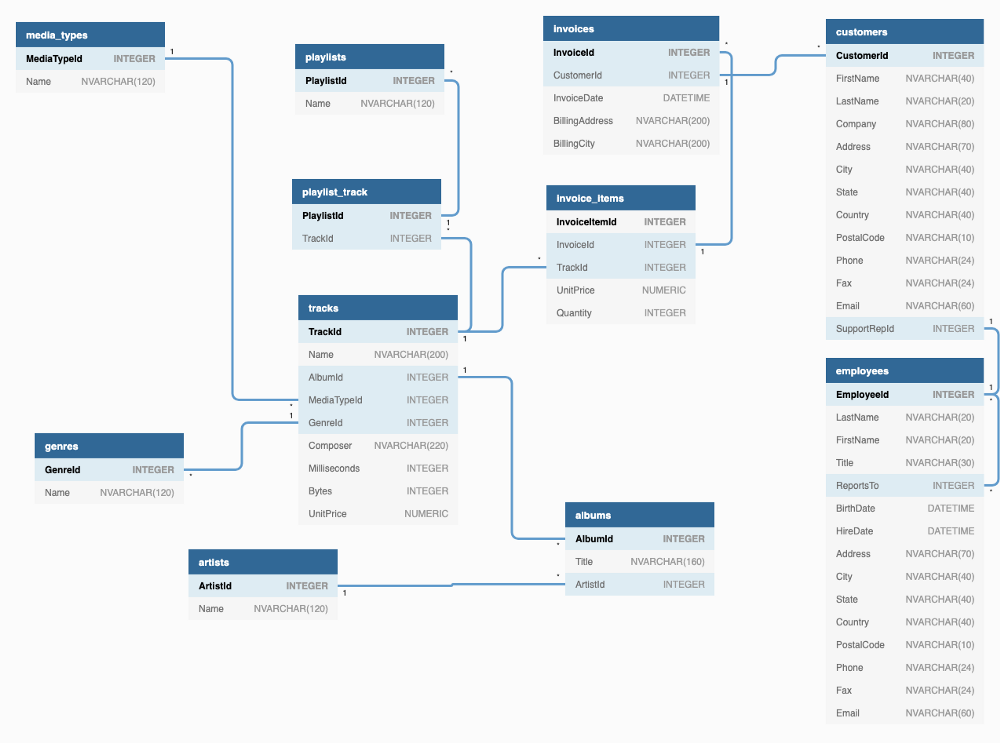

We can see all tables that are inside with the following query

In [ ]:
query = "SELECT name FROM sqlite_master WHERE type='table'"
sql_query(query)

In [ ]:
pd.read_sql(query, connection)

## 3. Queries
Write the *query* in order to select which data to bring from the data base. The queries have this structure:

```SQL
SELECT field1, field2, field3...
FROM a_table
WHERE conditions
```

**Reserved SQL keywords are usually capitalized** in order to differenciate them from the rest.

We wouldn't get an error as **SQL is not case sensitive**.

### 3.1 First query

In [ ]:
# Show entire tracks table
query = """
SELECT *
FROM 'tracks'
"""
sql_query(query)

### 3.2 SELECT
**The sentence `SELECT` filters columns**. We can even rename columns inside `SELECT`. Two options:
- **SELECT * :** in this way we bring ALL data. It's not recomendable because we may download unnecesary data, which will reduce performance. **Databases are shared resources between more users** and probably the query will be used in a pipeline, so a human may not even see the data at all.

- **SELECT field1, field...:** selects the exact data that we need.

If you want to rename a column it is done with the syntax `field AS new_name`. **If you want to use spaces in the name, you need to use double quotation marks**

SQL is not case sensitive

In [ ]:
query = "SELECT name FROM sqlite_master WHERE type='table'"
sql_query(query)

In [ ]:
# From the tracks table, rename "Name" to "SongName" and also show the column "Composer"
query = """
SELECT Name as "SongName", Composer
FROM tracks
"""
sql_query(query)

### 3.3 LIMIT
It is used to reduce the rows returned. Always at the end. For example `LIMIT 10`

In [ ]:
# Limit to 10 rows the previous table
query = """
SELECT Name as 'SongName', Composer
FROM tracks
LIMIT 10
"""
sql_query(query)

### 3.4 DISTINCT
It is used to obtain ALL unique rows. Useful to remove dupplicates, or to see all options inside a certain column.

**It may be very slow with tables with thousands or millions of rows.**

In [ ]:
# Show all composers from the database
query = """
SELECT DISTINCT Composer
FROM tracks
"""
sql_query(query)

### 3.5 WHERE
It is used to filter rows. For example:
* **Single numeric value**
    * UnitPrice = 0.99
    * UnitPrice >= 0.99
    * UnitPrice < 0.99
* **Single string value**: Name = 'Restless and Wild'
* **Different values**: GenreId in (1, 5, 12)
* **String contained in**:
    * strings that start with 'A': Name like 'A%'
    * strings that end in A': Name like '%A'
    * strings that contain 'A' at some point in the middle: Name like '%A%'
* **Distinct of**: UnitPrice <> 0.99

`WHERE`

In [ ]:
# Filter the table tracks showing only those with a unitary price above 0.99
query = """
SELECT *
FROM tracks
WHERE (UnitPrice > 0.99) AND (AlbumId = 226)
"""
sql_query(query)

`LIKE`

In [ ]:
# Filter the table tracks so we can get the songs composed by "Brian Johnson"
query = """
SELECT *
FROM tracks
WHERE Composer LIKE '%Brian Johnson'
"""
sql_query(query)

`WHERE` with several arguments

In [ ]:
# Filter the table tracks to obtain the songs with a unitary value greater than 0.99 and more than 100_000_000 bytes
# and the genre identifier to be 21, 22 or 23
query = """
SELECT *
FROM Tracks
WHERE (UnitPrice > 0.99)
AND (Bytes > 100000000)
AND (GenreId = 21 OR TrackId = 22 OR TrackID = 23)
"""
sql_query(query)

### 3.6 ORDER BY
We can **order the table with the the field that we want**
By default ORDER BY orders the strings alphabetically and numeric data is ordered from smaller to greater.
To sort the other way around, you need to use `DESC` like `ORDER BY field DESC`

In [ ]:
# Order the table tracks by name in descending order
query = """
SELECT *
FROM tracks
ORDER BY Name DESC
"""

sql_query(query)

### 3.7 Aggregations
In some ocasiones we may want to use a statistical value like the maximum of a field, it's standard deviation or simply a count of non null values. So, we may use functions like `MAX`, `COUNT` or `AVG`.
In [this page](https://www.sqlservertutorial.net/sql-server-aggregate-functions/) there is a summary of the most important functions.

In [ ]:
# Count the number of songs that start with the letter 'A'
query = """
SELECT COUNT(DISTINCT Name) AS QtTracks
FROM tracks
WHERE Name LIKE 'A%'
"""
sql_query(query)

In [ ]:
# What is the maximum unitary price from the table invoice_items?
query = """
SELECT MAX(UnitPrice)
FROM tracks
"""
sql_query(query)

### 3.8 GROUP BY
Useful sentence for **computing aggregates used in another field**. For example, to compute the mean of the unitary price by genre.


In [ ]:
# Obtain the mean of the unitary prices by genre in the table tracks
query = """
SELECT GenreID, AVG(UnitPrice) as TotalPrice
FROM tracks
GROUP BY GenreID
ORDER BY TotalPrice DESC
LIMIT 10
"""

sql_query(query)

Or calculate how many songs have written each composer.

In [ ]:
query = """
SELECT Composer, COUNT(TrackId) as QtTracks
FROM tracks
-- WHERE Composer <> 'None'
GROUP BY Composer
ORDER BY QtTracks DESC
-- LIMIT 1
"""

sql_query(query)

In [ ]:
query = """
SELECT Composer, COUNT(Composer) as QtTracks
FROM tracks
-- WHERE Composer <> 'None'
GROUP BY Composer
ORDER BY QtTracks DESC
-- LIMIT 1
"""

sql_query(query)

### 3.9 JOIN
Until now we've seen how to do queries with a single table, but **what if we want to use data from different tables?**
That is done with `JOIN` operations, and for that is needed to use **one or different common values in both tables, called KEYS**.

**When to use them ?** For example, if we have a table with a set of clients and we want to add new fields, we need to get to other tables with the client identifier  and apply a `JOIN`.

Or, for example, we have a table with all the orders with many fields (city, directions, client...) and in another table we have only the numbers of the orders that weren't delivered. If you want to filter the total table of orders by the orders that weren't delivered, you may apply an `INNER JOIN` in order to have the common values, being the identifier the order number.

Different types of JOINs:

![SQL JOINS](./img/joins.jpg)

In [ ]:
# Join the table tracks and genres with an INNER JOIN, showing the columns name and composer (from tracks) and name (from genres)
# Filter the rows so that the genre starts with B

query='''
SELECT tra.Name AS TrackName ,
        tra.Composer,
        gen.Name as GenreName
FROM tracks tra
JOIN genres gen
ON tra.GenreId = gen.GenreId
WHERE GenreName LIKE 'B%' -- gen.Name
'''
sql_query(query)

In [ ]:
# Join the table tracks and invoice_item with a LEFT JOIN, showing the columns trackid, name and composer from the table tracks,
# and invoicelineid, invoiceid from the table invoice_items
query = '''
SELECT tra.trackId, tra.Name, tra.Composer, inv.InvoiceLineId, inv.InvoiceId
FROM tracks tra
LEFT JOIN invoice_items inv
ON tra.trackId = inv.trackId
'''
sql_query(query)

In [ ]:
# Join the table tracks and albums with a LEFT JOIN, showing the columns trackid, name and albumid from the table tracks,
# and the column title from the table albums
query = '''
SELECT tra.TrackId, tra.Name, tra.AlbumId, alb.Title
FROM tracks tra
LEFT JOIN albums alb
ON tra.AlbumId = tra.AlbumId
'''
sql_query(query)

<table align="left">
 <tr><td width="80"><img src="./img/error.png" style="width:auto;height:auto"></td>
     <td style="text-align:left">
         <h3>ERRORS</h3>
 </td></tr>
</table>

Errors are all of the same type: `OperationalError`. That shows that the error is generated by SQL, rather than Python interpreter.
It even shows the specific row where is the error located.

In [ ]:
query = '''
SEECT * 
FROM tracks
'''

sql_query(query)

In [ ]:
query = '''
SELECT * 
FROM tracksssss
'''

sql_query(query)

In [ ]:
query = '''
SELECT field1, field2
FROM tracks
'''

sql_query(query)

## 5. Summary
**SQL is the standard used to access relational databases**, so almost every company uses this kind of database.
SQL syntaxis is:

```SQL
SELECT field1, field2, field3...
FROM a_table
WHERE conditions
```
With some actions:
1. **Filter columns**: `SELECT`
2. **Rename fields**: `SELECT field as new_name`
3. **Delete dupplicates**: `DISTINCT`
4. **Limit the number of rows**: `LIMIT`
5. **Filter rows**: `WHERE`
6. **Order a table**: `ORDER BY field1, field2, and `DESC`
7. **Add data**: get a a KPI like : `MAX`,`COUNT`,`AVG`...
8. **Add data at group level**: with `GROUP BY`. The aggregation function is computed for each column.
9. **Join data**: `JOIN` with different types: `LEFT`, `RIGHT`, `FULL`, `INNER` and `OUTER`.
10. **Temporal tables**: with `VIEW`
11. **Delete tables or views**: with `DROP`

Also the data may be obtained with sqlite3 **and processed afterwards with pandas.**